# Partial dependence plots (PDP)

Partial Dependence Plots (PDPs) help us understand the relationship between a feature (or two features) and the predicted outcome of a model. The key idea is to see how changing the value of a feature affects the prediction, while **averaging out** the effects of all other features. A PDP can be very useful to unveil the nature of a relationship, for example by letting us see whether it is linear or not. 

Consider a case where we fit a model to predict the wholesale electricity price using as input the temperature, the time of the day, and the day of the week. Using PDPs, we would like to explore the specific form of influence that each variable has on the predicted response. To explore that, let's now generate some data where the Price is a function of temperature, hour, and day. The effect we will generate, and that we expect to find from the PDPs are:
- **Temperature**: the typical banana shape we have seen in previous examples, where prices increase as we move away from mild temperatures. This means that the price will be higher when the temperature is either very low or very high, and lower when the temperature is moderate, forming a U-shaped curve.
- **Hour**: a sinusoidal pattern throughout the day, with two peaks and one trough. We expect higher prices in the morning (between 7 AM and 10 AM) and in the evening (between 6 PM and 10 PM) due to increased demand during these times. The prices will be lower in the afternoon (between 10 AM and 5 PM), reflecting decreased demand.
- **Day**: higher prices on Sundays compared to the rest of the week. This simulates the effect of increased electricity consumption on weekends when people are more likely to be at home.

In [1]:
import numpy as np
import pandas as pd

# Simulate data
np.random.seed(0)
n_samples = 1000
temperature = np.random.uniform(0, 40, n_samples)  # Temperature in Celsius
time_of_day = np.random.uniform(0, 24, n_samples)  # Time of day in hours
day_of_week = np.random.randint(0, 7, n_samples)  # Day of the week (0=Sunday, 6=Saturday)

price = (0.2 * (temperature - 20)**2 +  # Quadratic effect of temperature
         5 * np.sin((time_of_day - 7) * np.pi / 6) * (time_of_day >= 7) * (time_of_day <= 10) +  # Smooth peak between 7 AM and 10 AM
         5 * np.sin((time_of_day - 18) * np.pi / 4) * (time_of_day >= 18) * (time_of_day <= 22) +  # Smooth peak between 6 PM and 10 PM
         -5 * np.sin((time_of_day - 10) * np.pi / 7) * (time_of_day >= 10) * (time_of_day <= 17) +  # Smooth trough between 10 AM and 5 PM
         7 * np.sin((time_of_day) * np.pi / 24) +  # Sinusoidal effect throughout the day
         5 * (day_of_week == 0) +  # Higher prices on Sunday
         np.random.normal(0, 2, n_samples) * 2)  # Noise

# Convert to DataFrame for convenience
data = pd.DataFrame({
    'Temperature': temperature,
    'Hour': time_of_day,
    'Day': day_of_week,
    'Price': price
})

# Display the first few rows
data.head()

,Temperature,Hour,Day,Price
0,21.952540,14.229126,3,-2.181208
1,28.607575,0.241529,3,14.646904
2,24.110535,11.419829,3,7.310915
3,21.795327,17.010489,5,6.542792
4,16.946192,1.055410,4,-1.502707


Using the **semi-parametric causal discovery methods** we discussed in the previous chapters, we might now be able to discover the true causal structure of the data-generating process. However, we will still not be able to see the **specific shape of the relationship** between a feature (or a set of features) and the predicted outcome. Now, we assume we already have some knowledge on the true causal structure, and want to use some approaches to further characterise the dependency patterns.

Imagine we fitted a model $\hat{f}$ that predicts the electricity price using the remaining three features as input variables. Let $h$ represent the hour variable. The partial dependence function $\hat{f}(h)$ is defined as:

\begin{equation}
    \hat{f}(h) = E_{\mathbf{x}}[\hat{f}(h, \mathbf{x})] = \int \hat{f}(h, \mathbf{x}) dP(\mathbf{x})
\end{equation}


where:
- $h$ is the feature of interest (e.g., the hour of the day). It can also be computed for a set of features instead of a single one.
- $\mathbf{x}$ is the vector of all other features in the dataset except $h$.
- $\hat{f}$ is the model, and $\hat{f}(h, \mathbf{x})$ is the prediction made by the model for given $h$ and $\mathbf{x}$ values.
- $E_{\mathbf{x}}$ denotes the expectation over the marginal distribution of $\mathbf{x}$.

The **partial dependence function** shows how the model's prediction changes when $h$ changes, keeping the other features constant. Taking the expected value of the model’s prediction over the distribution of $\mathbf{x}$ effectively averages out the effects of all other features. Indeed, the The integral indicates that we are integrating (or averaging) the model’s predictions over the probability distribution of the features in $\mathbf{x}$. This integration helps in isolating the effect of $h$ on the predicted outcome.

In practice, we estimate $\hat{f}(h)$ using the average prediction over the dataset:

\begin{equation}
    \hat{f}(h) \approx \frac{1}{n} \sum_{i=1}^n \hat{f}(h, \mathbf{x}_i)
\end{equation}

where $n$ is the number of instances in the dataset, and $\mathbf{x}_i$ is the $i$th observation of the covariates. This sum basically calculates the average prediction of the model when $h$ is fixed at a specific value, and $\mathbf{x}$ iterates through all the observed values in the dataset. Here is what we would do in practice:
1. **Fix the feature of interest**: pick a specific value of the feature $h$ (e.g., Hour = 8 AM).
2. **Pair it with all other features**: for each data point in the dataset, replace the value of the feature $h$ with the fixed value (e.g., set Hour to 8 AM for all instances), while keeping the other feature values $\mathbf{x}$ as they are.
3. **Make predictions**: use the fitted model to make predictions for all these modified data points.
4. **Average these predictions**: calculate the average of these predictions. **This average actually represents the partial dependence value $\hat{f}(h, \mathbf{x})$.

By iteratively fixing $h$ at specific values and averaging over all the remaining features, we are actually trying to **isolate the influence** of changing hours, while keeping the other values constant.


To see this in practice, let's manually implement the PDP for the "Hour" feature. This will illustrate the steps involved in calculating and plotting a PDP. Here is a simple implementation of a function to estimate the **partial dependence function**: 

In [2]:
def calculate_pdp(feature_name, feature_values, X, model):
    pdp_values = []
    for value in feature_values: # Step 1
        X_temp = X.copy()
        X_temp[feature_name] = value # Step 2
        predictions = model.predict(X_temp) # Step 3
        pdp_values.append(np.mean(predictions))  # Step 4
    return pdp_values

Let's now apply it to a random forest regression model fitted to the data we generated before:

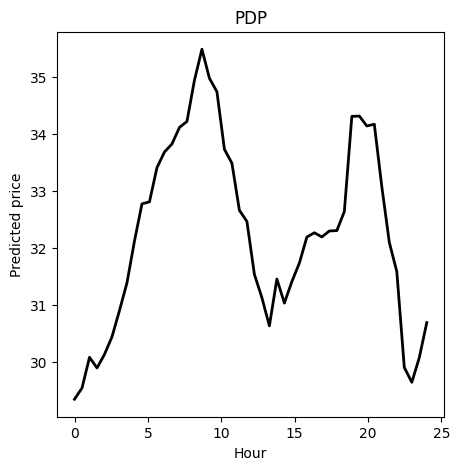

In [3]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Split data into features and target
x = data[['Temperature', 'Hour', 'Day']]
y = data['Price']

# Train a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=10, random_state=0)
rf.fit(x, y)

# Calculate PDP for the "Hour" feature
hour_values = np.linspace(0, 24, 48)  # Range of hour values to evaluate
pdp_hour = calculate_pdp(feature_name='Hour', feature_values=hour_values, X=x, model=rf)

# Plot the manually calculated PDP
plt.figure(figsize=(5, 5))
plt.plot(hour_values, pdp_hour, color='k', linewidth=2)
plt.title('PDP')
plt.xlabel('Hour')
plt.ylabel('Predicted price')
plt.show()

We can see how the PDP shows the pattern we expected, as the time of the day affects the price through the peak morning and evening hours. Now, we can apply the function we implemented to the remaining features too. To obtain more reliable estimates, we can **repeat the procedure many times**, and plot the mean dependence lines, along with some **Bootstrap confidence intervals**.

In [4]:
# Define the range of values for each feature
temperature_values = np.linspace(0, 35, 70)
hour_values = np.linspace(0, 24, 48)
day_values = np.arange(7)

# Calculate PDPs with bootstrapping
n_bootstraps = 100
pdp_temperature_bootstraps = []
pdp_hour_bootstraps = []
pdp_day_bootstraps = []

for _ in range(n_bootstraps):
    # Bootstrap sample
    indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
    x_bootstrap = x.iloc[indices]
    y_bootstrap = y.iloc[indices]
    
    # Train model on bootstrap sample
    model_bootstrap = RandomForestRegressor(n_estimators=10, random_state=0)
    model_bootstrap.fit(x_bootstrap, y_bootstrap)
    
    # Calculate PDPs for each feature
    pdp_temperature = calculate_pdp('Temperature', temperature_values, x, model_bootstrap)
    pdp_hour = calculate_pdp('Hour', hour_values, x, model_bootstrap)
    pdp_day = calculate_pdp('Day', day_values, x, model_bootstrap)
    
    pdp_temperature_bootstraps.append(pdp_temperature)
    pdp_hour_bootstraps.append(pdp_hour)
    pdp_day_bootstraps.append(pdp_day)

We basically repeated the estimation procedure 100 times. Now, we can use a basic approach and simply take the empirical 2.5% and 97.5% percentiles to obtain a 95% confidence interval for the partial dependence functions.

In [5]:
pdp_temperature_bootstraps = np.array(pdp_temperature_bootstraps)
pdp_hour_bootstraps = np.array(pdp_hour_bootstraps)
pdp_day_bootstraps = np.array(pdp_day_bootstraps)

# Compute mean and confidence intervals
mean_pdp_temperature = np.mean(pdp_temperature_bootstraps, axis=0)
mean_pdp_hour = np.mean(pdp_hour_bootstraps, axis=0)
mean_pdp_day = np.mean(pdp_day_bootstraps, axis=0)
ci_temperature = np.percentile(pdp_temperature_bootstraps, [2.5, 97.5], axis=0)
ci_hour = np.percentile(pdp_hour_bootstraps, [2.5, 97.5], axis=0)
ci_day = np.percentile(pdp_day_bootstraps, [2.5, 97.5], axis=0)

Let's now plot the result!

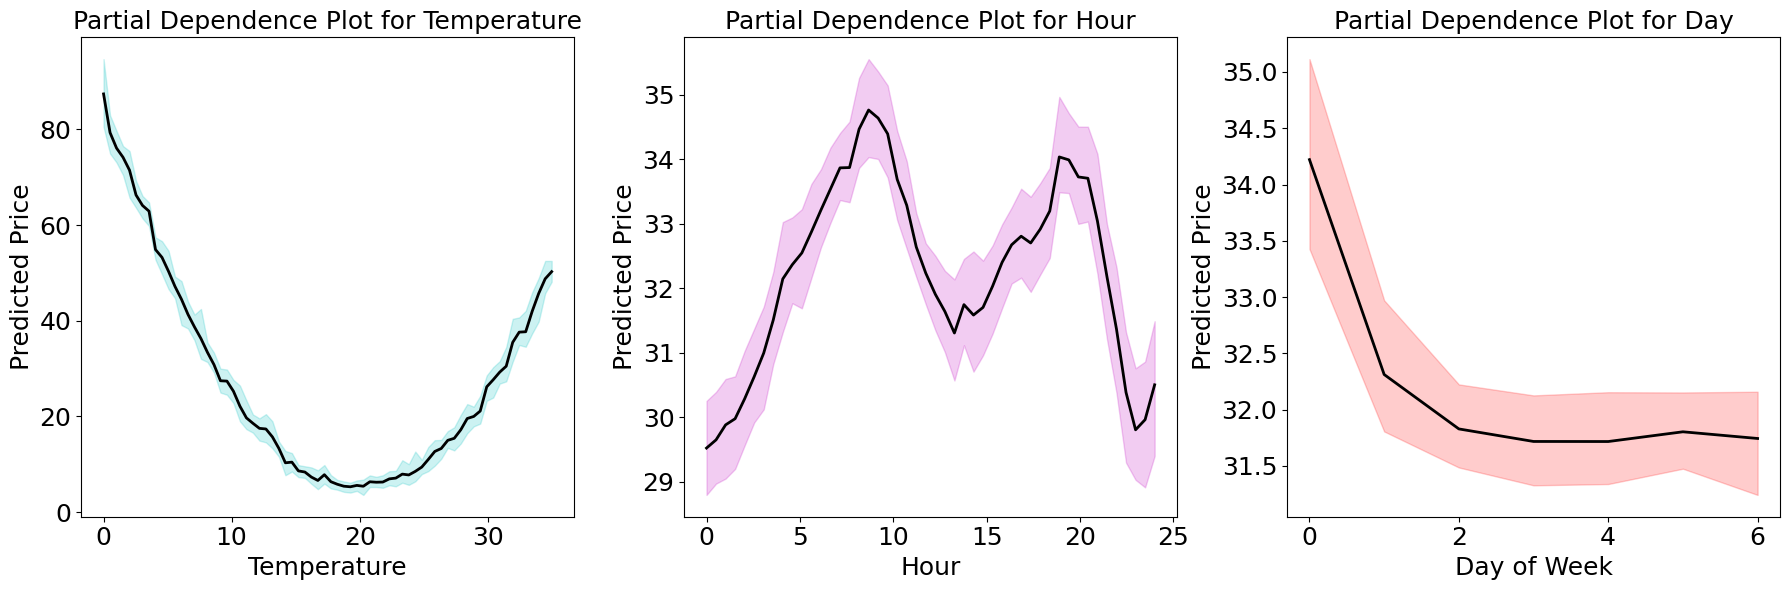

In [6]:
# Plot PDPs with confidence intervals
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

fontsize = 18  # Set the font size for all labels

# Temperature
ax[0].plot(temperature_values, mean_pdp_temperature, label='Partial Dependence', color='k', linewidth=2)
ax[0].fill_between(temperature_values, ci_temperature[0], ci_temperature[1], color='c', alpha=0.2)
ax[0].set_title('Partial Dependence Plot for Temperature', fontsize=fontsize)
ax[0].set_xlabel('Temperature', fontsize=fontsize)
ax[0].set_ylabel('Predicted Price', fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)

# Hour
ax[1].plot(hour_values, mean_pdp_hour, label='Partial Dependence', color='k', linewidth=2)
ax[1].fill_between(hour_values, ci_hour[0], ci_hour[1], color='m', alpha=0.2)
ax[1].set_title('Partial Dependence Plot for Hour', fontsize=fontsize)
ax[1].set_xlabel('Hour', fontsize=fontsize)
ax[1].set_ylabel('Predicted Price', fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)

# Day
ax[2].plot(day_values, mean_pdp_day, label='Partial Dependence', color='k', linewidth=2)
ax[2].fill_between(day_values, ci_day[0], ci_day[1], color='r', alpha=0.2)
ax[2].set_title('Partial Dependence Plot for Day', fontsize=fontsize)
ax[2].set_xlabel('Day of Week', fontsize=fontsize)
ax[2].set_ylabel('Predicted Price', fontsize=fontsize)
ax[2].tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.show()